<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

This is a starter notebook for the guided project [Transfer Learning for NLP with TensorFlow Hub](https://www.coursera.org/projects/transfer-learning-nlp-tensorflow-hub/)

A complete version of this notebook is available in the course resources.

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, you will use pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

### Learning Objectives

By the time you complete this project, you will be able to:

- Use various pre-trained NLP text embedding models from TensorFlow Hub
- Perform transfer learning to fine-tune models on your own text data
- Visualize model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

### Prerequisites

In order to be successful with this project, it is assumed you are:

- Competent in the Python programming language
- Familiar with deep learning for Natural Language Processing (NLP)
- Familiar with TensorFlow, and its Keras API

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: TensorFlow Hub for Natural Language Processing
- **[Task 5]()**: Define Function to Build and Compile Models
- **[Task 6]()**: Define Function to Build and Compile Models(Continued...)
- **[Task 7]()**: Train Various Text Classification Models
- **[Task 8]()**: Compare Accuracy and Loss Curves
- **[Task 9]()**: Fine-tuning Models from TF Hub
- **[Task 10]()**: Train Bigger Models and Visualize Metrics with TensorBoard

## Task 2: Setup your TensorFlow and Colab Runtime.

You will only be able to use the Colab Notebook after you save it to your Google Drive folder. Click on the File menu and select “Save a copy in Drive…

![Copy to Drive](https://drive.google.com/uc?id=1CH3eDmuJL8WR0AP1r3UE6sOPuqq8_Wl7)


### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [ ]:
!nvidia-smi

Sat Oct 22 16:51:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.9.2
Hub version:  0.12.0
GPU is available


## Task 3: Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
df= pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression="zip", low_memory=False)
df.shape


(1306122, 3)

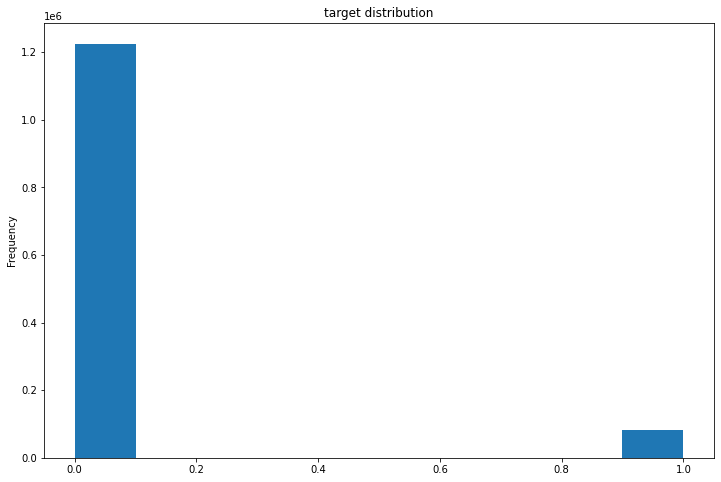

In [ ]:
df['target'].plot(kind='hist', title="target distribution")

In [ ]:
from sklearn.model_selection import train_test_split
train_df, remaining= train_test_split(df, random_state=42, train_size=0.01, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.001, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [ ]:
train_df.target.head(15).values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
train_df.question_text.head(15).values

array(['What is your experience living in Venezuela in the current crisis? (2018)',
       'In which state/city the price of property is highest?',
       'Do rich blacks also call poor whites, “White Trash”?',
       'Should my 5 yr old son and 2 yr old daughter spend the summer with their father, after a domestic violent relationship?',
       'Why do we have parents?',
       'Do we experience ghost like Murphy did in Interstellar?',
       'Are Estoniano women beautiful?',
       'There was a Funny or Die video called Sensitivity Hoedown that got pulled. Does anyone know why?',
       'Is it a good idea to go in fully mainstream classes, even if I have meltdowns that might disrupt people?',
       'What classifies a third world country as such?',
       'Is being a pilot safe?',
       'Who is Illiteratendra Modi? Why does he keep with him a Rs 1 lakh pen?',
       'Have modern management strategies such as Total supply Chain Management applied to education? Can they be?',
       '

## Task 4: TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

You can think of a question vector as a distributed representation of a question, and is computed for every question in the training set. The question vector along with the output label is then used to train the statistical classification model. 

The intuition is that the question vector captures the semantics of the question and, as a result, can be effectively used for classification. 

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP: 
* word-based representations and 
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Tasks 5 & 6: Define Function to Build and Compile Models

In [ ]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
  hub_layer=hub.KerasLayer(module_url, input_shape=[],output_shape=[embed_size],dtype=tf.string, trainable=trainable)
  model=tf.keras.models.Sequential([
      hub_layer,
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1,activation="sigmoid")
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name="accuracy")])
  model.summary()
  history=model.fit(train_df['question_text'],train_df["target"],
                    epochs=100,
                    batch_size=32,
                    validation_data=(valid_df["question_text"],valid_df["target"]),
                    callbacks=[tfdocs.modeling.EpochDots(),
                               tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=2,mode="min"),
                               tf.keras.callbacks.TensorBoard(logdir/name)],
                    verbose=0)
  return history
  

  

## Task 7: Train Various Text Classification Models

In [ ]:
histories={}

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
histories['universal-sentence-encoder-large']=train_and_evaluate_model(module_url, embed_size=512,name='universal-sentence-encoder-large',trainable=False)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________

Epoch: 0, accuracy:0.9374,  loss:0.3000,  val_accuracy:0.9381,  val_loss:0.1710,  
...........

## Task 8: Compare Accuracy and Loss Curves

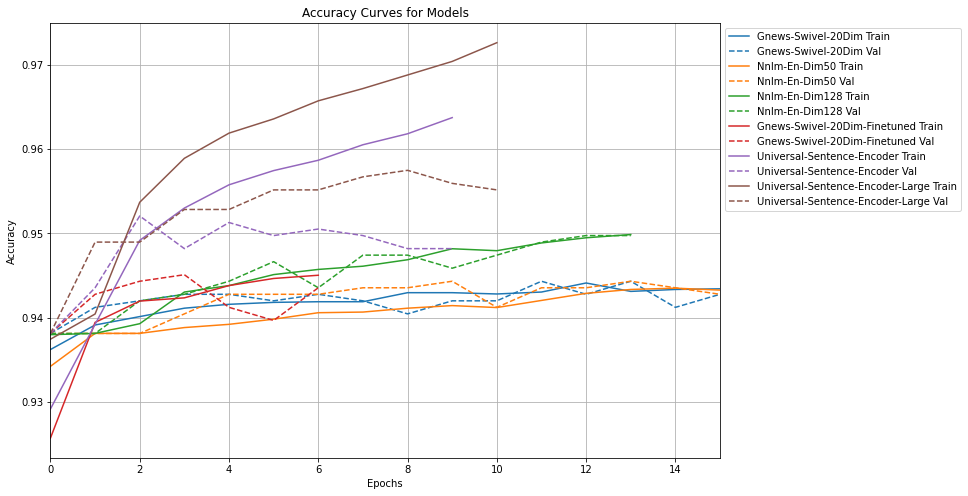

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

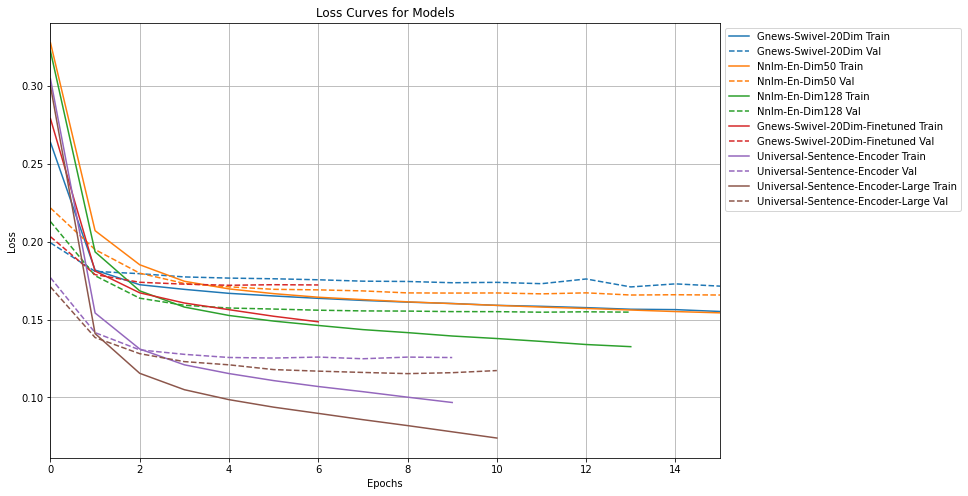

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(histories)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 9: Fine-tune Model from TF Hub

## Task 10: Train Bigger Models and Visualize Metrics with TensorBoard

In [ ]:
%load_ext tensorboard



In [ ]:
%tensorboard --logdir {logdir}